<a href="https://colab.research.google.com/github/majis18/Senior_thesis/blob/main/programing_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境構築

## PyTorch Geometricのインストール

In [1]:
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## グラフを作成しよう

In [2]:
import torch
from torch_geometric.data import Data

# エッジの接続
edge_from = [0, 1, 2]  # 接続元
edge_to = [2, 0, 1]  # 接続先
edge_index = torch.tensor([edge_from, edge_to], dtype=torch.long)

# 各ノードの特徴量
x_0 = [0, 1]
x_1 = [2, 3]
x_2 = [4, 5]
x = torch.tensor([x_0, x_1, x_2], dtype=torch.float)

# 各ノードのラベル
y_0 = [0]
y_1 = [1]
y_2 = [2]
y = torch.tensor([y_0, y_1, y_2], dtype=torch.float)

data = Data(x=x, y=y, edge_index=edge_index)
print(data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops6narrow4callERKNS_6TensorElll
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_diag_cuda.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warnings.warn(f"An issue occurr

Data(x=[3, 2], edge_index=[2, 3], y=[3, 1])


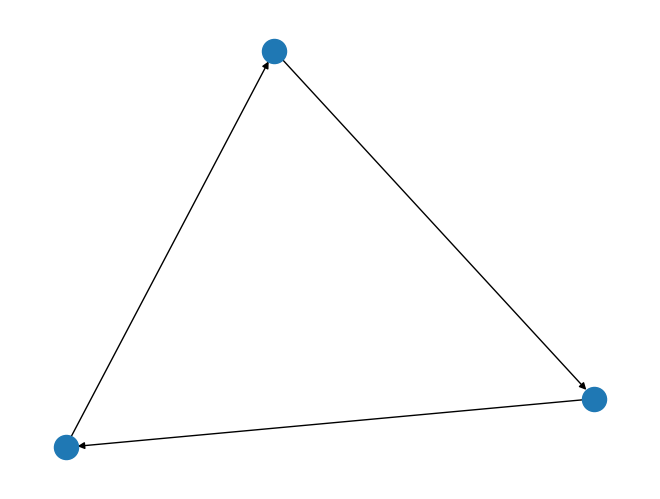

In [3]:
from torch_geometric.utils import to_networkx
import networkx as nx

nxg = to_networkx(data)  # networkxのグラフに変換
nx.draw(nxg)

# モデル構築

## データセットの読み込み

In [4]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

In [5]:
def print_info(data):

    print("ノードの数:", data.num_nodes)
    print("エッジの数:", data.num_edges)
    print("特徴量の数:", data.num_node_features)
    print("無向グラフか？:", data.is_undirected())
    print("孤立したノードが有るか？:", data.has_isolated_nodes())
    print("自己ループがあるか？:", data.has_self_loops())

    print()

    print("キー: ", data.keys)
    print("各ノードの特徴量")
    print(data["x"])
    print("各ノードのラベル")
    print(data["y"])
    print("各エッジ")
    print(data["edge_index"])

In [6]:
print_info(data)

ノードの数: 2708
エッジの数: 10556
特徴量の数: 1433
無向グラフか？: True
孤立したノードが有るか？: False
自己ループがあるか？: False

キー:  ['val_mask', 'train_mask', 'y', 'edge_index', 'test_mask', 'x']
各ノードの特徴量
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
各ノードのラベル
tensor([3, 4, 4,  ..., 3, 3, 3])
各エッジ
tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


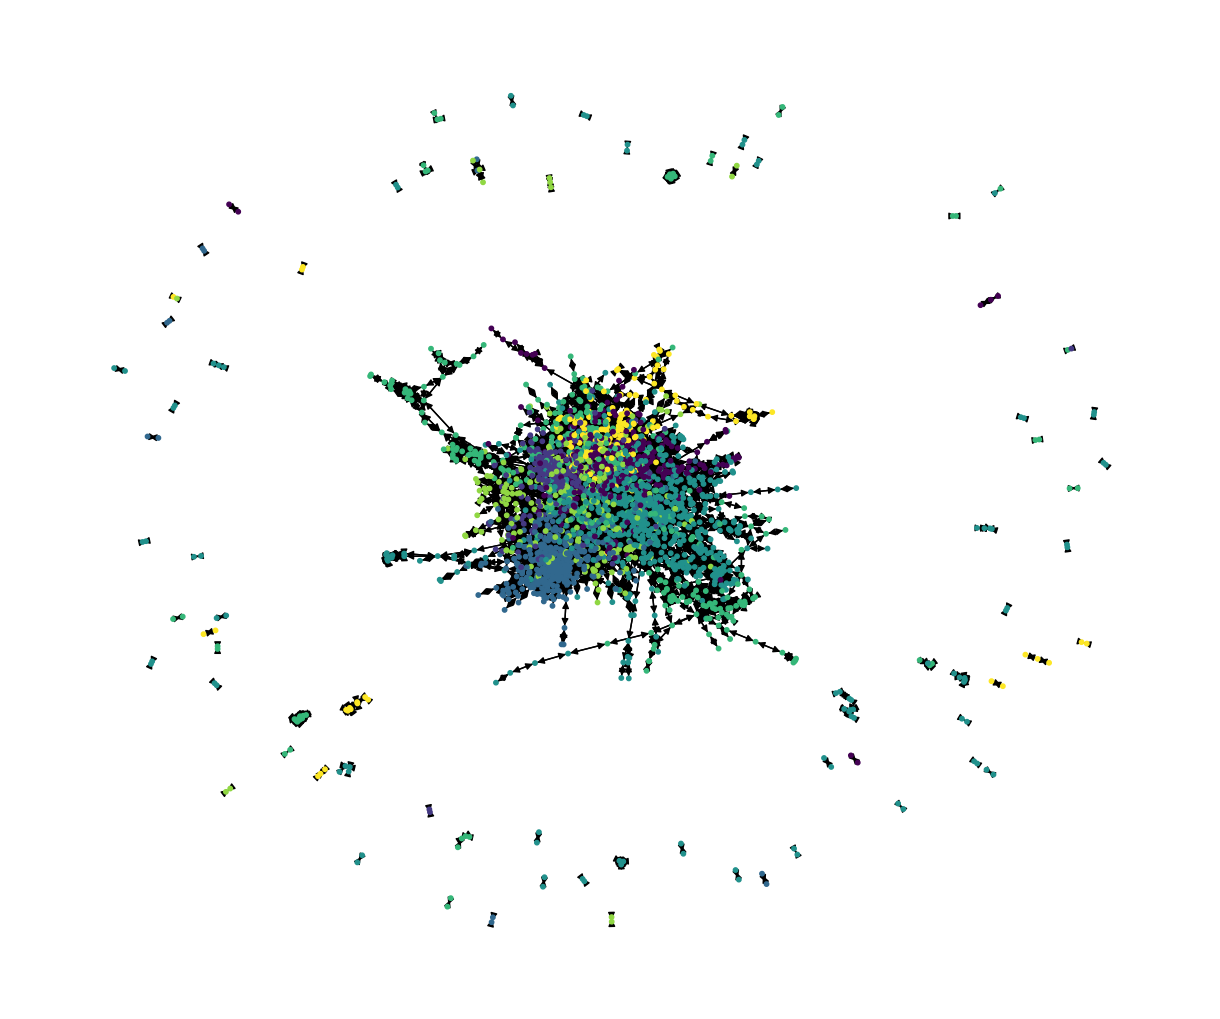

In [7]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

data_nx = to_networkx(data)  # networkxのグラフに変換

plt.figure(figsize=(12, 10))
nx.draw(data_nx,
        node_color = data.y,
        node_size=10)
plt.show()

## モデルの構築

In [10]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.relu = nn.ReLU()  # ReLU
        self.conv2 = GCNConv(32, dataset.num_classes)
    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x
net = GCN()
net.cuda()

GCN(
  (conv1): GCNConv(1433, 32)
  (relu): ReLU()
  (conv2): GCNConv(32, 7)
)

## 学習

In [11]:
from torch import optim
data = data.cuda()  # GPU対応
loss_fnc = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
net.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = net(data)
    loss = loss_fnc(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

## 評価

In [12]:
net.eval()
pred = net(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
accuracy = int(correct) / int(data.test_mask.sum())
print("正解率:", str(accuracy*100) + "%")

正解率: 78.4%
